<a href="https://colab.research.google.com/github/linkjavier/disco/blob/felipe/models/lstm_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From book: Generative AI with Python and TensorFlow 2 By Joseph Babcock and Raghav Bali

LSTM-Attention Model for Music Generation

In [1]:
import os
import pickle
import numpy as np
from music21 import note, chord, converter, stream, instrument
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
"""
Run this code if you have not saved "until_179" and "180_to_295"
into a folder named "pickle_folder" in your Google Drive.
This is to save time and RAM in future runs.
"""
!unzip '/content/drive/MyDrive/classical_music_midi_295.zip'

In [ ]:
"""
Run this code if you have not saved "until_179"
into a folder named "pickle_folder" in your Google Drive.
This is to save time and RAM in future runs.
"""
data_dir = 'classical_music_midi_295'

midi_list = os.listdir(data_dir)

# Load and make list of stream objects
original_scores = []
for midi in tqdm(midi_list[:180]):
    score = converter.parse(os.path.join(data_dir,midi))
    original_scores.append(score)

In [ ]:
"""
Run this code if you have not saved "until_179"
into a folder named "pickle_folder" in your Google Drive.
This is to save time and RAM in future runs.
"""
store_folder = 'parsed_data'

if not os.path.exists(store_folder):
    os.mkdir(store_folder)

# Merge notes into chords
"""
Make chords out of non-chords. Chordify powerful tool for reducing a complex
score with multiple parts to a succession of chords in one part that represent
everything that is happening in the score.
"""
original_scores = [midi.chordify() for midi in tqdm(original_scores)]

with open(os.path.join(store_folder, 'until_179'), 'wb') as f:
    pickle.dump(original_scores, f)

In [ ]:
"""
Run this code if you have not saved "180_to_295"
into a folder named "pickle_folder" in your Google Drive.
This is to save time and RAM in future runs.
"""
data_dir = 'classical_music_midi_295'

midi_list = os.listdir(data_dir)

# Load and make list of stream objects
original_scores = []
for midi in tqdm(midi_list[180:295]):
    score = converter.parse(os.path.join(data_dir,midi))
    original_scores.append(score)

In [ ]:
"""
Run this code if you have not saved "180_to_295"
into a folder named "pickle_folder" in your Google Drive.
This is to save time and RAM in future runs.
"""
store_folder = 'parsed_data'

if not os.path.exists(store_folder):
    os.mkdir(store_folder)

# Merge notes into chords
original_scores = [midi.chordify() for midi in tqdm(original_scores)]

with open(os.path.join(store_folder, '180_to_295'), 'wb') as f:
    pickle.dump(original_scores, f)

In [2]:
def piken():
  """
  Save time and RAM consumption.
  Returns: original scores from dataset
  """
  original_scores = [] 
  path = 'drive/MyDrive/pickle_folder'
  midi_list = os.listdir(path)
  for file in tqdm(midi_list):
    score = open('{}/{}'.format(path, file),'rb')
    scores = pickle.load(score)
    original_scores += scores
  return original_scores

original_scores = piken()

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# Extract chords, durations, and keys
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

for i, midi in tqdm(enumerate(original_scores)):
    original_keys.append(str(midi.analyze('key')))
    for element in midi:
        if type(element) is note.Note:
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif type(element) is chord.Chord:
            original_chords[i].append('.'.join(str(n) for n in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

0it [00:00, ?it/s]

In [4]:
# Lists of chords and durations from songs in C major
major_chords = [c for (c, k) in tqdm(zip(original_chords, original_keys)) if (k == 'C major')]
major_durations = [c for (c, k) in tqdm(zip(original_durations, original_keys)) if (k == 'C major')]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # notes and durations to integers and vice versa
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [6]:
# sets of notes and durations
note_names, n_notes = get_distinct([n for chord in major_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in major_durations for d in dur])

In [7]:
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)

In [8]:
# Set sequence length
sequence_length = 32

# train data
train_chords = []
train_durations = []
# supervised learning
target_chords = []
target_durations = []

# Build train and target sequences for chords and durations
# Sliding window
for s in range(len(major_chords)):
    chord_list = [note_to_int[c] for c in major_chords[s]]
    duration_list = [duration_to_int[d] for d in major_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])
        target_chords.append(chord_list[i+1])
        target_durations.append(duration_list[i+1])

In [9]:
train_chords = np.array(train_chords)
train_durations = np.array(train_durations)
target_chords = np.array(target_chords)
target_durations = np.array(target_durations)

In [10]:
def create_network(n_notes, n_durations, embed_size, rnn_units):

    # two parallel inputs
    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # added LSTM layer to improve learning of long sequences
    x = LSTM(rnn_units, return_sequences=True)(x)

    # added LSTM layer to improve learning of long sequences
    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
    # two paralell outputs                                
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    opt = optimizer=Adam()
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=opt)

    return model

In [11]:
embed_size = 128
rnn_units = 128

In [12]:
model = create_network(n_notes, n_durations, embed_size, rnn_units)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    860800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    2688        input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
if not os.path.exists('outputs'):
    os.mkdir('outputs')

if not os.path.exists('outputs/weights'):
    os.mkdir('outputs/weights')

In [15]:
output_folder = 'outputs'
weights_folder = os.path.join(output_folder, 'weights')

checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss',
    restore_best_weights=True,
    patience = 5
)

callbacks_list = [
    checkpoint,
    early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))

In [16]:
history = model.fit([train_chords, train_durations], 
                    [target_chords, target_durations],
                    epochs=100, batch_size=128,
                    callbacks=callbacks_list,
                    shuffle=True
                  )

Epoch 1/100
262/262 [==============================] - 24s 46ms/step - loss: 8.4139 - pitch_loss: 7.6765 - duration_loss: 0.7374
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


262/262 [==============================] - 11s 43ms/step - loss: 7.2610 - pitch_loss: 6.8108 - duration_loss: 0.4502
Epoch 3/100
262/262 [==============================] - 11s 43ms/step - loss: 6.7171 - pitch_loss: 6.3587 - duration_loss: 0.3583
Epoch 4/100
262/262 [==============================] - 11s 43ms/step - loss: 6.1350 - pitch_loss: 5.9082 - duration_loss: 0.2268
Epoch 5/100
262/262 [==============================] - 11s 43ms/step - loss: 5.5186 - pitch_loss: 5.4095 - duration_loss: 0.1091
Epoch 6/100
262/262 [==============================] - 11s 43ms/step - loss: 5.0451 - pitch_loss: 4.9702 - duration_loss: 0.0749
Epoch 7/100
262/262 [==============================] - 11s 43ms/step - loss: 4.6707 - pitch_loss: 4.6089 - duration_loss: 0.0618
Epoch 8/100
262/262 [==============================] - 11s 43ms/step - loss: 4.2931 - pitch_loss: 4.2460 - duration_loss: 0.0471
Epoch 9/100
262/262 [==============================] - 11s 43ms/step - loss: 4.0369 - pitch_loss: 3.9888 - du

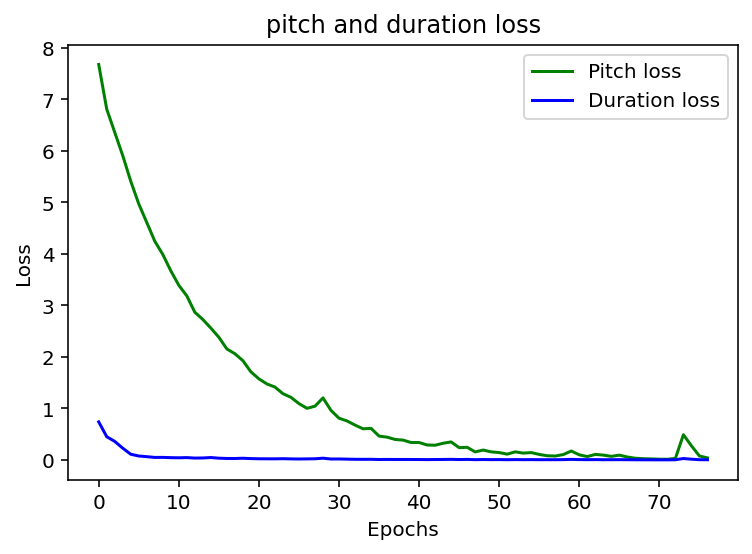

In [17]:
# https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib
pitch_loss = history.history['pitch_loss']
duration_loss = history.history['duration_loss']

# set 'epochs' according to the above result
epochs = 77
epochs = range(epochs)
plt.plot(epochs, pitch_loss, 'g', label='Pitch loss')
plt.plot(epochs, duration_loss, 'b', label='Duration loss')
plt.title('pitch and duration loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
"""
Too much randomness in the output is not good, as it can lead to incoherent
results.

Temperature is a tunable parameter to control the amount of randomness.
Temperature helps to increase the likelihood of high probability terms while
reducing the likelihood of low probability ones. High temperature leads to more
randomness, while lower temperature brings in predictability.
"""
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [19]:
# chord and duration sequences
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [20]:
initial_chords

array([[1647, 1647, 1647, 1647, 1647, 1647, 1376, 2644, 3602, 4645, 3602,
        2644, 2644, 2644, 2644, 2644, 2644, 3268, 3602, 4242, 5992,  101,
         626,  626,  626, 1376, 1376,  101,  101,  101, 1647, 1647]])

In [21]:
initial_durations

array([[ 8,  2,  2,  8,  2,  2,  2, 11,  2,  2,  2,  8,  2,  2,  8,  2,
         2,  2, 11,  2,  2,  2,  8,  2,  2, 11,  2,  8,  2,  2, 11,  2]])

In [22]:
# Predict chords and durations
def predict_chords(chord_sequence, duration_sequence, model, temperature):
    predicted_chords, predicted_durations = model.predict([chord_sequence,
                                                           duration_sequence])
    return sample_with_temp(predicted_chords[0], temperature), sample_with_temp(predicted_durations[0], temperature)

In [23]:
# Generated chords and durations
new_chords, new_durations = [], []

# Generate chords and durations using 60 rounds of prediction
for j in range(60):
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

print("new_chords", new_chords)
print("new_durations", new_durations)

new_chords [1647, 1647, 1647, 1647, 1647, 1376, 2644, 3602, 4645, 3602, 2644, 2644, 2644, 2644, 2644, 2644, 3268, 3602, 4242, 5992, 101, 626, 626, 626, 1376, 1376, 101, 101, 101, 1647, 1647, 1647, 1647, 1647, 1647, 1647, 1376, 2644, 3602, 4645, 3602, 2644, 2644, 2644, 2644, 2644, 2644, 3268, 3602, 4242, 5992, 101, 626, 626, 626, 1376, 1376, 101, 101, 101]
new_durations [2, 2, 8, 2, 2, 2, 11, 2, 2, 2, 8, 2, 2, 8, 2, 2, 2, 11, 2, 2, 2, 8, 2, 2, 11, 2, 8, 2, 2, 11, 2, 2, 2, 8, 2, 2, 2, 11, 2, 2, 2, 8, 2, 2, 8, 2, 2, 2, 11, 2, 2, 2, 8, 2, 2, 11, 2, 8, 2, 2]


In [24]:
# Create stream object
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())

# Add notes and durations to stream
for j in range(len(new_chords)):
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          quarterType = int_to_duration[new_durations[j]]))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                            quarterType = int_to_duration[new_durations[j]]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm_att_adam_295_midi_1.mid')

'lstm_att_adam_295_midi_1.mid'